In [1]:
import sys, os; sys.path.append("/".join(os.getcwd().split("/")[:-1])); os.chdir("..")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import Reporter, Table

In [3]:
# Theming
COLORS = ['#2196F3', '#EF5350', '#81C784', '#FF9800', '#3F51B5', '#FFCA28', '#F48FB1', '#673AB7', '#AED581', '#795548']
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=COLORS)
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.color'] = '#CCCCCC'
plt.rcParams['figure.figsize'] = (8, 4.5) # 16/9 aspect ratio
font = {
        'size'   : 14}

plt.rc('font', **font)

In [4]:
# Get result table and event reporter
rTable = Table("results/resultTable.json").export()
# reporter = Reporter(log_dir=f'runs/{run_id}', comment=comment)

In [5]:
rTable

,RunId,Category,Experiment,Hyperparameters,Configuration,accuracy,precision,crossEntropy,Status,Last Modified
Run Id,,,,,,,,,,
1,1,defaultCategory,experiments.experiment1,cpu:False\nfract:1.0,configs/E_s.yml,0.601002,0.588940,0.886896,CREATED,2024-11-08 20:26:11.595033
2,2,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/E_s.yml,0.590376,0.585658,0.901660,CREATED,2024-11-10 11:51:32.359919
3,3,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/E_m.yml,0.598316,0.552634,0.887066,CREATED,2024-11-11 13:52:20.977199
4,4,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/C_s.yml,0.371832,0.185916,1.094200,CREATED,2024-11-12 16:47:22.396668
5,5,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/C_t.yml,0.371832,0.185916,1.093272,CREATED,2024-11-13 08:46:34.801265
6,6,defaultCategory,experiments.experiment1,cpu:False\nfract:0.1,configs/V_16.yml,0.373696,0.186848,1.093082,CREATED,2024-11-14 07:10:52.446584
7,7,defaultCategory,experiments.experiment1,comment:New training loop and data processing\...,configs/E_s.yml,0.595751,0.565942,0.890143,CREATED,2024-11-15 22:10:56.677439
8,8,defaultCategory,experiments.experiment1,comment:New training loop and data processing\...,configs/E_s.yml,0.595996,0.554180,0.890694,CREATED,2024-11-17 11:25:33.294967
9,9,defaultCategory,experiments.experiment2,dataset:small\ncpu:False\nnoscaler:False\nfrac...,configs/paper_2.yml,0.530109,0.482563,0.709141,CREATED,2024-11-19 12:31:31.387381


# TODO
- Find naive performances for each datasets (and compare)
- Visual comparaison between our images and their images
- Figure showing how much money you would make if their algorithm would work

# Reimplementation
The first step of our investigation is to try to reproduce the result of the paper. They add 92% of accuracy on the Taiwan50 dataset.
We implemented their methodology as it was described. We used the same model, the same number of datapoints and the same method of rendering.

Text(0.5, 0, 'Implementation')

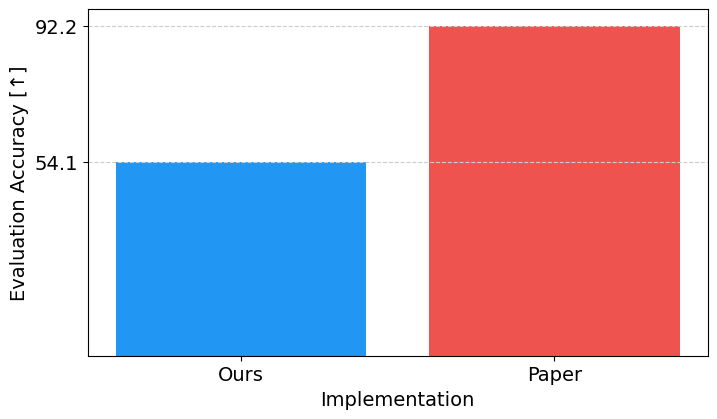

In [33]:
runID = 10
perf = rTable.loc[runID]
our_acc = perf["accuracy"] * 100
their_acc = 92.2
names = ["Ours", "Paper"]
plt.bar(names, [our_acc, their_acc], color=COLORS[:2])
plt.yticks([our_acc, their_acc])
# plt.ylim(0.60, 0.62)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

Well, this doesn't look the same. We revised our code, and we didn't find any mismatch between our implementatio and the detailed methodology. However, it fells kinf of fishy to be able to predict the **future** 92% of the time. (It is a whole other level of accuracy). With that accuracy, one could become the richest man in the world really quickly (**TODO: Make figure**) To know more, we tried to investigate.

# New representation
The authors of the paper used matplotlib finance to render the time series in a visual representation. However, this technique is really slow (around 2fps). We implemented our own renderer (**TODO: show image comparaison**), Which is 1000x faster (Around 2,000fps). Being able to use that rendering method would greatly speed up experiment, and make it possible to make bigger experiment. Here, we test the difference in performances between both methods.

Text(0.5, 0, 'Implementation')

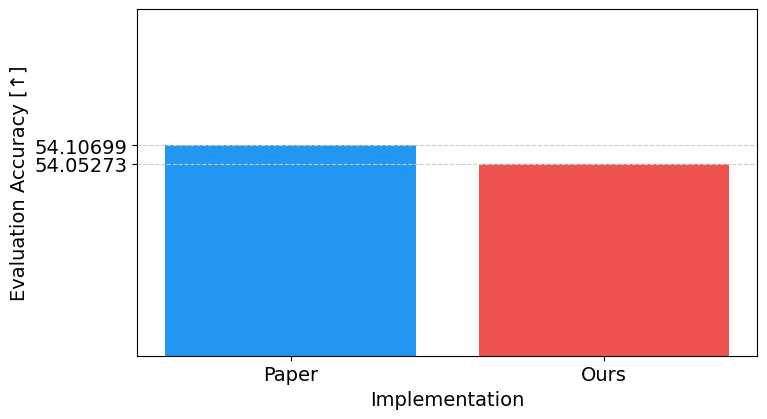

In [36]:
runID = [10, 11]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["Paper", "Ours"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
plt.ylim(53.5, 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

Text(0.5, 0, 'Implementation')

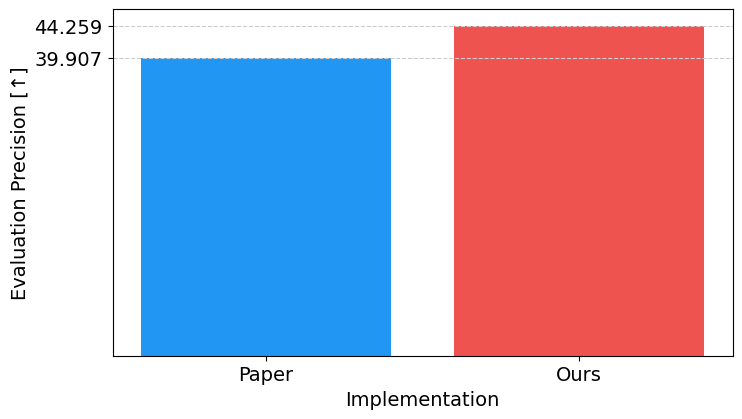

In [37]:
runID = [10, 11]
acc = [100 * rTable.loc[rid]["precision"] for rid in runID]
names = ["Paper", "Ours"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
# plt.ylim(53., 54.5)
plt.ylabel("Evaluation Precision [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

Since the difference in performances is small, we continue to use our rendering method for the rest of the project

# Problem: Task or model
In this section, we wanted to see if the problem was the task that was too hard or the model that was incapable of learning useful features. We created two alternative task that doesn't requires to predict the future. (Task are described in the lab report for experiment 2 in the method section)

## Task: Up or Down

Text(0.5, 0, 'Implementation')

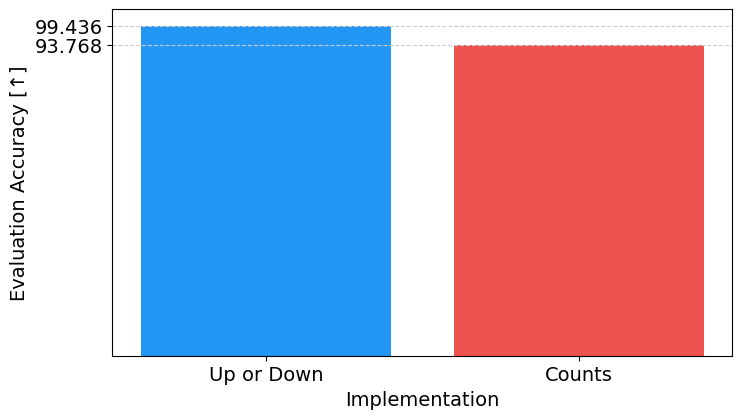

In [17]:
runID = [13, 15]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["Up or Down", "Counts"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
# plt.ylim(53., 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

A we can see, the model is really good at extracting patterns and *reasoning*. This suggest that the task is difficult. (Which is intuitive)

# Different market, different distribution?
For all previous experiments, we did them on the taiwan stock market. However, the US stock market is more interesting because it contains more stocks and more liquidity. This is why we would like to see how the model perform on an other market. Will it be better or worst? To keep analog condition, we made a dataset of the 50 most valuable US compagnies. TW50 is the same, but for taiwanese stocks.

Text(0.5, 0, 'Implementation')

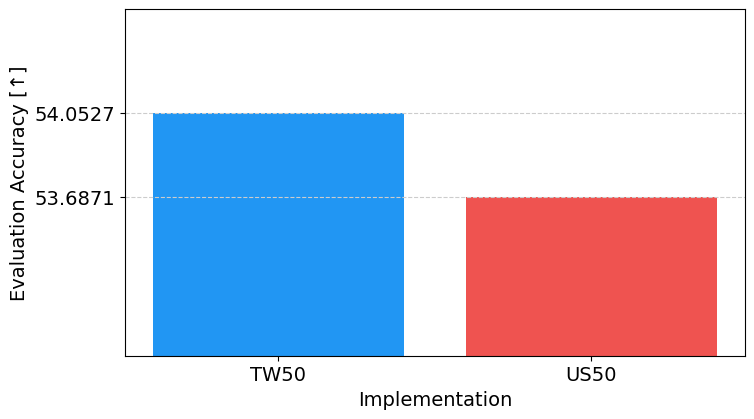

In [19]:
runID = [11, 16]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["TW50", "US50"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks(acc)
plt.ylim(53., 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

['Step/Loss', 'Step/accuracy', 'Step/precision', 'Train/accuracy', 'Train/precision', 'Train/Loss', 'Valid/accuracy', 'Valid/precision', 'Valid/Loss']


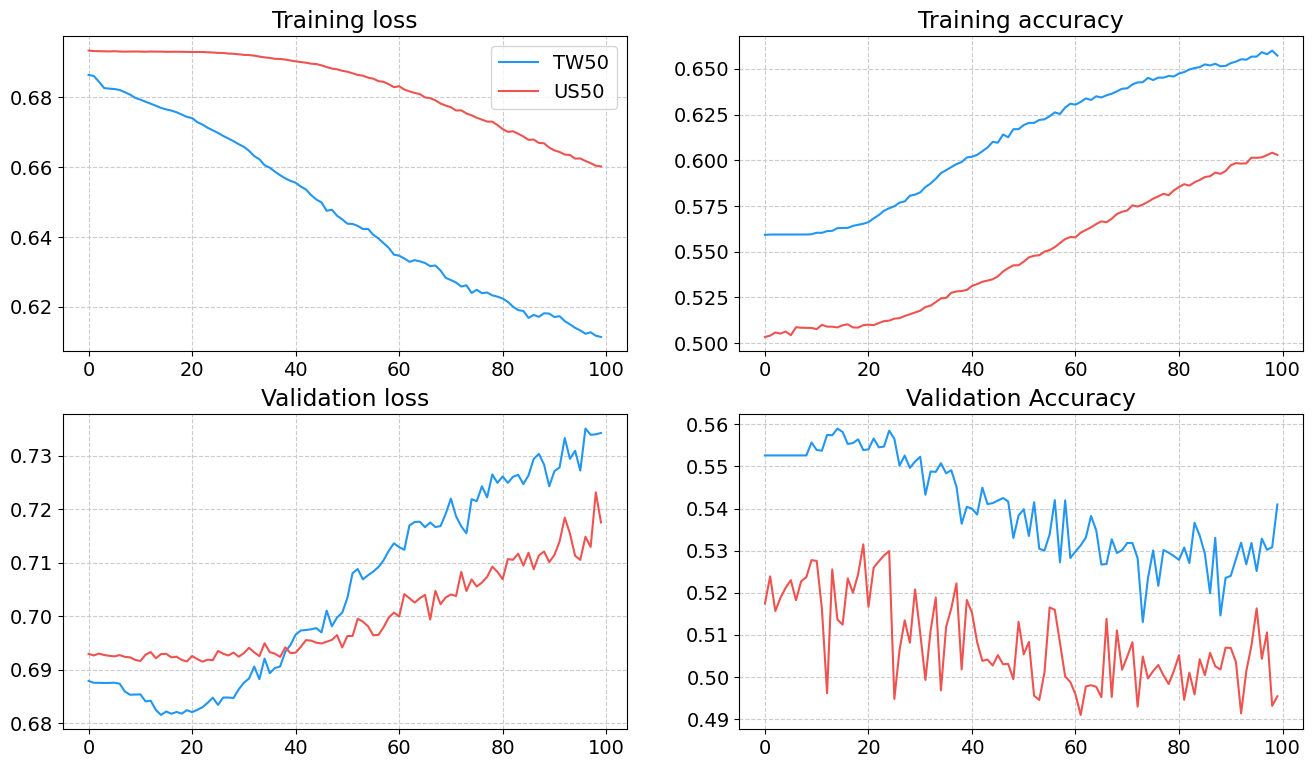

In [32]:
reporterTW = Reporter(log_dir=f'runs/{runID[0]}')
reporterUS = Reporter(log_dir=f'runs/{runID[1]}')
print(reporter.keys)
# Load values
train_loss_tw = reporterTW["Train/Loss"]["value"].values
train_loss_us = reporterUS["Train/Loss"]["value"].values
train_acc_tw = reporterTW["Train/accuracy"]["value"].values
train_acc_us = reporterUS["Train/accuracy"]["value"].values
val_loss_tw = reporterTW["Valid/Loss"]["value"].values
val_loss_us = reporterUS["Valid/Loss"]["value"].values
val_acc_tw = reporterTW["Valid/accuracy"]["value"].values
val_acc_us = reporterUS["Valid/accuracy"]["value"].values

# Plot
fig, ax = plt.subplots(2, 2, figsize=(16, 9))

ax[0, 0].plot(train_loss_tw, label="TW50")
ax[0, 0].plot(train_loss_us, label="US50")
ax[0, 0].set_title("Training loss")
ax[0, 0].grid()
ax[0, 0].legend()
ax[0, 1].plot(train_acc_tw, label="TW50")
ax[0, 1].plot(train_acc_us, label="US50")
ax[0, 1].set_title("Training accuracy")
ax[0, 1].grid()
ax[1, 0].plot(val_loss_tw, label="TW50")
ax[1, 0].plot(val_loss_us, label="US50")
ax[1, 0].set_title("Validation loss")
ax[1, 0].grid()
ax[1, 1].plot(val_acc_tw, label="TW50")
ax[1, 1].plot(val_acc_us, label="US50")
ax[1, 1].set_title("Validation Accuracy")
ax[1, 1].grid()

Again, similar performances, but different training dynamic. This suggest a fundamental difference between both datset. (Domain shift)

# Different model

Next, we try a more capable model. Afterall, maybe it is just that the model doesn't have the capacity to learn the task
- Take a SOTA CV model
- EfficietNetV2 small (20M parameters VS 0.35M)

Text(0.5, 0, 'Implementation')

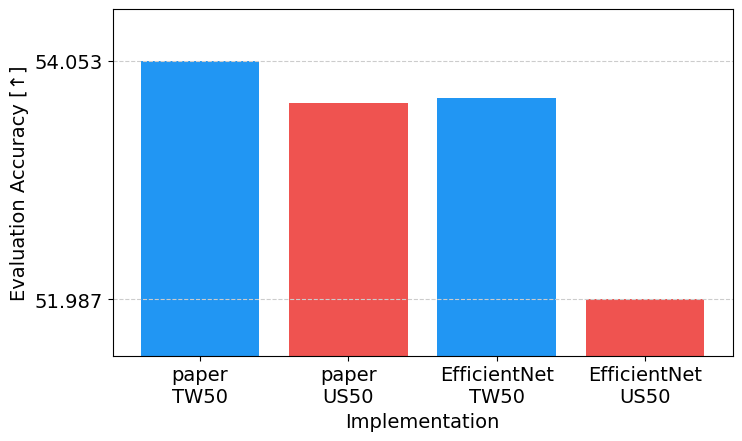

In [45]:
runID = [11, 16, 18, 17]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
names = ["paper\nTW50", "paper\nUS50", "EfficientNet\nTW50", "EfficientNet\nUS50"]
plt.bar(names, acc, color=COLORS[:2])
plt.yticks([acc[0], acc[-1]])
plt.ylim(51.5, 54.5)
plt.ylabel("Evaluation Accuracy [↑]")
plt.grid(axis="y")
plt.xlabel("Implementation")

By looking at learning curves, we notice all the models were overfitting. Mainly EfficientNet

# Bigger dataset
Next, we wanted to evaluate how the dataset size would improve the evaluation performances, we trained on a dataset 8x bigger. (10% of all US stocks)

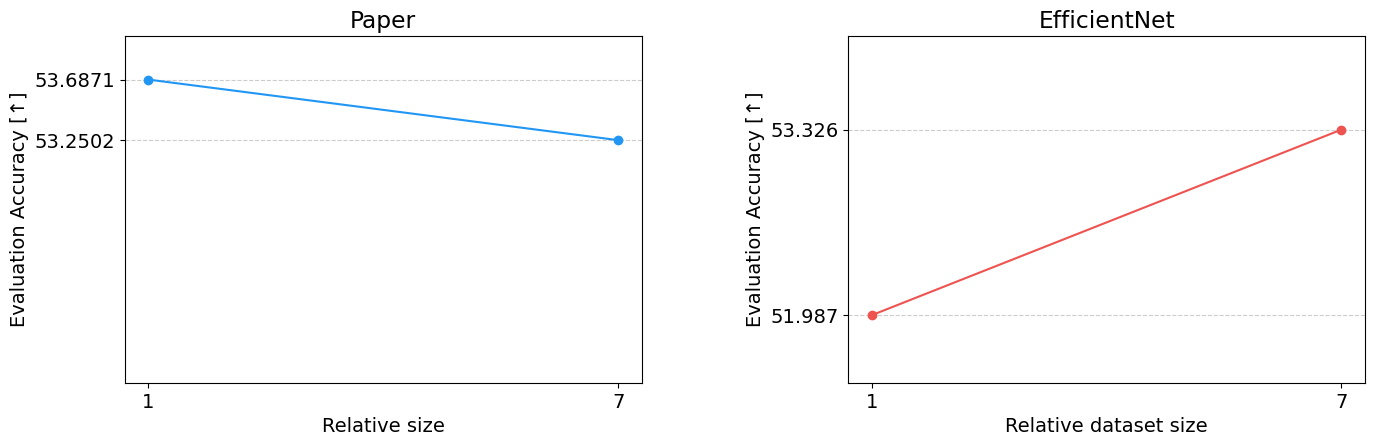

In [70]:
ds_size = [1, 7]
runID = [16, 21]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
fig, axs = plt.subplots(1, 2, figsize=(16, 4.5))
axs[0].plot(ds_size, acc, marker="o", color=COLORS[0])
axs[0].set_yticks(acc)
axs[0].set_ylim(51.5, 54)
axs[0].set_ylabel("Evaluation Accuracy [↑]")
axs[0].set_xticks(ds_size)
axs[0].set_xlabel("Relative size")
axs[0].grid(axis='y')
axs[0].set_title("Paper")

runID = [17, 20]
acc = [100 * rTable.loc[rid]["accuracy"] for rid in runID]
axs[1].plot(ds_size, acc, marker="o", color=COLORS[1])
axs[1].set_yticks(acc)
axs[1].set_ylim(51.5, 54)
axs[1].set_ylabel("Evaluation Accuracy [↑]")
axs[1].set_xticks(ds_size)
axs[1].set_xlabel("Relative dataset size")
axs[1].grid(axis='y')
axs[1].set_title("EfficientNet")
plt.subplots_adjust(wspace=0.4)

Makes sense, The bigger model gets an improvment while the smaller doesn't change much. However, we can see in the learning curves that there is still a lot of overfitting for the EfficientNet

The paper cited by this paper to which it compares itself uses a random train test split. Hypothesis: (Which causes dataleaking)